Import the libraries

The following code imports the required library.

If dont have matplotlib install with the follow command:
    
    !pip install matplotlib

In [26]:
# Imports libs
from ortools.sat.python import cp_model

# Import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Select the file provided and read the content

    file_path = "p01_dataset_20_new.txt"

Print output if its exist:

In [27]:
# Open the file in read mode

# file_path = "p01_dataset_8.txt"
# file_path = "p01_dataset_10.txt"
file_path = "p01_dataset_20_new.txt"
#file_path = "p01_dataset_30.txt"

try:
    with open(file_path, 'r') as file:
        # Read the contents of the file
        contents = file.read()
        # Print the contents
        print("File Contents:\n")
        print(contents)
except FileNotFoundError:
    print(f"The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

File Contents:

************************************************************************
#General Information
projects                      :  1
jobs (incl. supersource/sink ):  22
horizon                       :  92
RESOURCES
  - renewable                 :  2   R
  - nonrenewable              :  0   N
  - doubly constrained        :  0   D
************************************************************************
#Projects summary
pronr.  #jobs rel.date duedate tardcost  MPM-Time
    1     20      0       30       15      30 
************************************************************************
#Precedence relations
#jobnr.    #modes  #successors   successors
   1        1          3           2   3   4
   2        1          3           6   9  14
   3        1          3           5   8  11
   4        1          3          12  16  20
   5        1          2           9  17
   6        1          3           7  12  18
   7        1          2           8  17
   8        1         

In [28]:
# Function to read and parse the file
def parse_txt_file(file_path):
    data = {}
    section = None
    
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Skip lines with only stars or whitespace
                if line.strip().startswith('*') or not line.strip():
                    continue

                # Identify sections based on headers
                if line.startswith("#General Information"):
                    section = line.strip().lstrip("#")
                    data[section] = []
                elif line.startswith("#Projects summary"):
                    section = line.strip().lstrip("#")
                    data[section] = []
                elif line.startswith("#Precedence relations"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                elif line.startswith("#Duration and resources"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                elif line.startswith("#Resource availability"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                else:
                    # Add content to the current section
                    if section:
                        data[section].append(line.strip())

        # Process data into structured formats
        data['*General_Information'] = parse_general_information(data.get('General Information', []))
        data['*Projects_Summary'] = parse_projects_summary(data.get('Projects summary', []))
        data['*Precedence_Relations'] = parse_precedence_relations(data.get('Precedence relations', []))
        data['*Duration_and_Resources'] = parse_duration_and_resources(data.get('Duration and resources', []))
        data['*Resource_Availability'] = parse_resource_availability(data.get('Resource availability', []))
        
        return data

    except FileNotFoundError:
        print(f"The file '{file_path}' does not exist.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def parse_general_information(lines):
    info = {}
    for line in lines:
        if ":" in line:
            key, value = line.split(":", 1)
            info[key.strip()] = value.strip()
    return info

def parse_projects_summary(lines):
    headers = lines[0].split()
    values = lines[1].split()
    return dict(zip(headers, values))

def parse_precedence_relations(lines):
    headers = lines[0].split()
    headers.append("successors2")
    headers.append("successors3")
    relations = []
    for line in lines[1:]:
        values = line.split()
        while len(values) < 6:
            values.append("0")
        relations.append(dict(zip(headers, values)))
    return relations

def parse_duration_and_resources(lines):
    headers = lines[0].split()
    durations = []
    for line in lines[1:]:
        values = line.split()
        durations.append(dict(zip(headers, values)))
    return durations

def parse_resource_availability(lines):
    headers = lines[0].split()
    resources = []
    for line in lines[1:]:
        values = line.split()
        resources.append(dict(zip(headers, values)))
    return resources

def parse_job_data():
    # Parsing jobs
    jobs = []
    for datax in data['*Duration_and_Resources']:
        job_id = int(datax['#jobnr.'])
        duration = int(datax['duration'])
        resources = {key: int(value) for key, value in datax.items() if key.startswith('R')}
        jobs.append({'id': job_id, 'duration': duration, 'resources': resources})

    # Generate precedence_constraints
    precedence_constraints = []
    for relation in data['*Precedence_Relations']:
        job_id = int(relation['#jobnr.'])
        num_successors = int(relation['#successors'])
        for i in range(1, num_successors + 1):
            successor_key = f'successors{i}' if f'successors{i}' in relation else 'successors'
            successor = int(relation[successor_key])
            if successor != 0:
                precedence_constraints.append((job_id, successor))           
                
    # Generate resources dictionary
    resources = {item['#resource']: int(item['qty']) for item in data['*Resource_Availability']}

    projectTime = data['*Projects_Summary']['MPM-Time']
    
    return jobs, precedence_constraints, resources, projectTime

def plot_gantt_chart(jobs, solver, job_starts, job_ends):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))

    # Assign each job a unique color using a colormap
    colors = plt.cm.tab20.colors  # Get a list of colors from the tab20 colormap

    for i, job in enumerate(jobs):
        job_id = job['id']
        start = solver.Value(job_starts[job_id])
        end = solver.Value(job_ends[job_id])
        ax.barh(
            job_id, 
            end - start, 
            left=start, 
            color=colors[i % len(colors)],  # Cycle through colors if there are more jobs than colors
            edgecolor='black', 
            align='center', 
            label=f'Job {job_id}'
        )

    ax.set_yticks([job['id'] for job in jobs])
    ax.set_yticklabels([f'Job {job["id"]}' for job in jobs])
    ax.set_xlabel('Days')
    ax.set_ylabel('Jobs')
    ax.set_title('Job Schedule Project 1')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Jobs')
    plt.tight_layout()
    plt.show()

def print_job_schedule(jobs, solver, job_starts, job_ends):
    """
    Prints a textual representation of the job schedule.
    """
    print(f"{'Job ID':<10}{'Start Time':<15}{'End Time':<15}{'Duration':<10}")
    print("-" * 50)
    for job in jobs:
        job_id = job['id']
        start = solver.Value(job_starts[job_id])
        end = solver.Value(job_ends[job_id])
        duration = job['duration']
        print(f"{job_id:<10}{start:<15}{end:<15}{duration:<10}")


In [29]:
#Read file and parse data
data = parse_txt_file(file_path)

Define the data
the data for the problem.

    # Call the function to get File Structure    
    jobs, precedence_constraints, resources, projectExactTime = parse_job_data()

    This function call "parse_job_data()" function that read the file and create the follow data:

    jobs: All jobs tasks from "Duration_and_Resources"
    precedence_constraints:  All jobs information from "Precedence_Relations"
    resources: All jobs information from "Resource_Availability"
    projectExactTime: This variable is not considerated because em some cases is wrong.

Declare the model
The following code declares the model for the problem.

    model = cp_model.CpModel()

Define the variables
The following code defines the variables in the problem.
        
    start_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'start_{job_id}')
    end_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'end_{job_id}')

For each job, the program uses the model's NewIntVar method to create the variables:
    start_var: Start time of the job task.
    end_var: End time of the job task.

Define the constraints
The following code defines the constraints for the problem.

    # Precedences
    for before, after in precedence_constraints:        
        model.Add(job_starts[after] >= job_ends[before])

    # Force start with Job 1
    model.Add(job_starts[1] == 0)    
    
    # Resource
    for resource, intervals_with_usage in resource_intervals.items():
        intervals_only = [i[0] for i in intervals_with_usage]
        usages = [i[1] for i in intervals_with_usage]
        model.AddCumulative(intervals_only, usages, resources[resource])


Define the objective
The following code defines the objective in the problem.

    model.AddMaxEquality(makespan, [job_ends[j['id']] for j in jobs]) 
    model.Minimize(makespan)


Invoke the solver
The following code calls the solver.
    
    solver = cp_model.CpSolver()
    status = solver.Solve(model)


Display the results
The following code displays the results, including the optimal schedule and task intervals.

     # Output the results
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f'Best time schedule jobs (Minimized makespan): {solver.ObjectiveValue()}')
        print_job_schedule(jobs, solver, job_starts, job_ends)
    # Plot the Gantt chart
        plot_gantt_chart(jobs, solver, job_starts, job_ends)      
    else:
        print('No feasible solution found.')


Precedence Constraints: [(1, 2), (1, 3), (1, 4), (2, 6), (2, 9), (2, 14), (3, 5), (3, 8), (3, 11), (4, 12), (4, 16), (4, 20), (5, 9), (5, 17), (6, 7), (6, 12), (6, 18), (7, 8), (7, 17), (8, 15), (8, 16), (9, 10), (9, 13), (9, 16), (10, 12), (10, 20), (11, 14), (11, 15), (11, 19), (12, 19), (12, 21), (13, 15), (14, 18), (15, 21), (16, 21), (17, 19), (18, 20), (19, 22), (20, 22), (21, 22)]
Resources: {'R1': 6, 'R2': 9}
Best time schedule jobs (Minimized makespan): 30.0
Job ID    Start Time     End Time       Duration  
--------------------------------------------------
1         0              0              0         
2         0              2              2         
3         0              1              1         
4         0              4              4         
5         1              6              5         
6         2              3              1         
7         3              9              6         
8         9              11             2         
9         6       

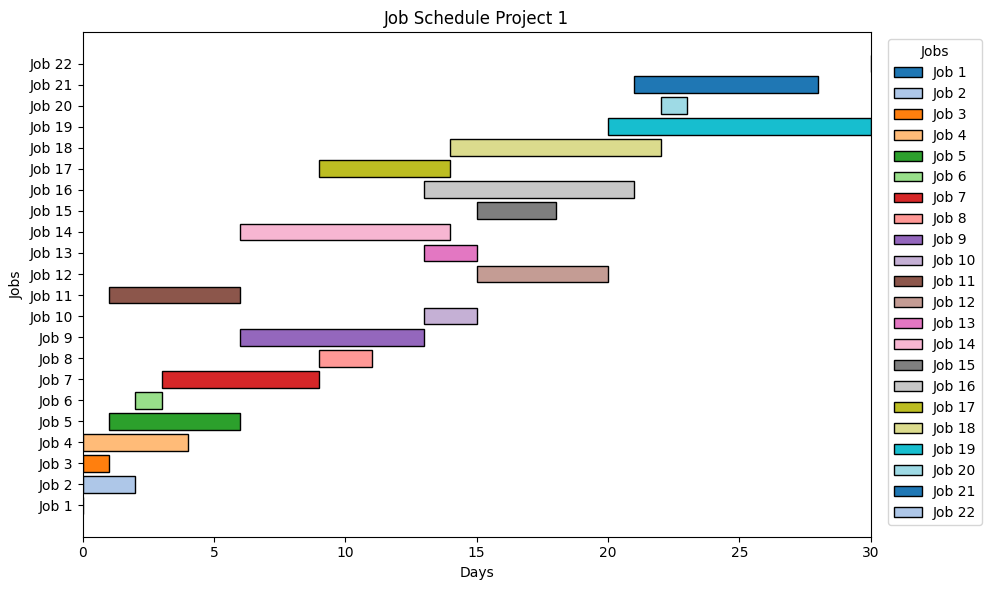

In [30]:
def main():   
    
    # Call the function to get File Structure    
    jobs, precedence_constraints, resources, projectExactTime = parse_job_data()

    # print("Domain jobs:", jobs)
    print("Precedence Constraints:", precedence_constraints)
    print("Resources:", resources)

    # Create the model
    model = cp_model.CpModel()

    job_starts = {}
    job_ends = {}
    intervals = []
    resource_intervals = {resource: [] for resource in resources}

    # Create Domain Variables
    ''' 
        jobs: Domain jobs[i] , i was the number of jobs
        start_var: The start time of each job.
        end_var: The end time of each job.
        interval_var: An interval variable that combines start_var, duration, and end_var.
        makespan: Represents the overall project completion time.
    '''
    
    for job in jobs:
        job_id = job['id']
        duration = job['duration']
        resource_usage = job['resources']
        
        start_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'start_{job_id}')
        end_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'end_{job_id}')
        interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job_id}')

        job_starts[job_id] = start_var
        job_ends[job_id] = end_var
        intervals.append(interval_var)

        for resource, usage in resource_usage.items():
            if usage > 0:
                resource_intervals[resource].append((interval_var, usage))

    # Apply Constrains
    # Precedences
    for before, after in precedence_constraints:        
        model.Add(job_starts[after] >= job_ends[before])

    # Force start with Job 1
    model.Add(job_starts[1] == 0)    
    
    # Resource
    for resource, intervals_with_usage in resource_intervals.items():
        intervals_only = [i[0] for i in intervals_with_usage]
        usages = [i[1] for i in intervals_with_usage]
        model.AddCumulative(intervals_only, usages, resources[resource])
    
    # The makespan is the latest time at which any job finishes. 
    # If the solver finds a solution that minimizes the makespan but doesn't start Job 1 at time 0
    # it may choose to start other jobs first based on resource or precedence constraints. 
    # In this case, the solver may be minimizing the total completion time, which could result in Job 1 starting later to achieve the best overall schedule.    
    
    sumDuration = sum(j['duration'] for j in jobs)
    makespan = model.NewIntVar(0, sumDuration, 'makespan')
    model.AddMaxEquality(makespan, [job_ends[j['id']] for j in jobs]) 
    
    # Minimize the makespan (overall project completion time)
    model.Minimize(makespan)
    
    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # Output the results
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f'Best time schedule jobs (Minimized makespan): {solver.ObjectiveValue()}')
        print_job_schedule(jobs, solver, job_starts, job_ends)
    # Plot the Gantt chart
        plot_gantt_chart(jobs, solver, job_starts, job_ends)      
    else:
        print('No feasible solution found.')

if __name__ == '__main__':
    main()
